In [1]:
from omegaconf import DictConfig,OmegaConf
conf = OmegaConf.load('config/config.yaml')
pic_=conf['config']['pic_']
tracking_uri_=conf['config']['tracking_uri']
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle5 as pickle
from catboost import Pool
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score,cohen_kappa_score,roc_auc_score,log_loss
import mlflow
from mlflow.tracking import MlflowClient

### [01 Preparation]

In [2]:
##Load data
data_sample=pd.read_csv("gs://bps-gcp-bucket/MLST2023/preprocessing/sample_"+str(pic_) +".csv",sep=',')
data_sample=data_sample

In [3]:
client = MlflowClient()
experiment = client.get_experiment_by_name("Modeling and Stacking")
exp_id=experiment.experiment_id
data_=mlflow.search_runs([exp_id], order_by=["metrics.f1_score DESC","metrics.log_loss ASC"])

In [4]:
data_

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.roc_auc,metrics.f1_score,metrics.cohen_kappa,metrics.log_loss,params.feature,params.classifier,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.source.name,tags.mlflow.source.type
0,b6f04ee1f46d462a8b473496a2598098,3,FINISHED,file:///home/jupyter-peta_admin/mlruns/3/b6f04...,2022-08-08 03:27:34.701000+00:00,2022-08-08 03:27:37.040000+00:00,0.945660,0.776419,0.686202,0.791373,"['B1_p15', 'B2_p15', 'B3_p15', 'B4_p15', 'B5_p...",catboost_wo_na,jupyter-peta_admin,catboost_wo_na,"[{""run_id"": ""b6f04ee1f46d462a8b473496a2598098""...",/opt/tljh/user/lib/python3.8/site-packages/ipy...,LOCAL
1,70ad6500d01a4bde9bfcac5bdd0d5eae,3,FINISHED,file:///home/jupyter-peta_admin/mlruns/3/70ad6...,2022-08-08 03:40:51.461000+00:00,2022-08-08 03:40:55.342000+00:00,0.943266,0.766305,0.657099,0.699878,"['B1_p15', 'B2_p15', 'B3_p15', 'B4_p15', 'B5_p...",stacking_combined,jupyter-peta_admin,stacking_combined,"[{""run_id"": ""70ad6500d01a4bde9bfcac5bdd0d5eae""...",/opt/tljh/user/lib/python3.8/site-packages/ipy...,LOCAL
2,faeb94d3db77465b879f93a893f0af2d,3,FINISHED,file:///home/jupyter-peta_admin/mlruns/3/faeb9...,2022-08-08 03:34:25.425000+00:00,2022-08-08 03:34:28.673000+00:00,0.941853,0.765746,0.654907,0.709184,"['B1_p15', 'B2_p15', 'B3_p15', 'B4_p15', 'B5_p...",stacking_wa,jupyter-peta_admin,stacking_wa,"[{""run_id"": ""faeb94d3db77465b879f93a893f0af2d""...",/opt/tljh/user/lib/python3.8/site-packages/ipy...,LOCAL
3,6d9b2d2a7b68476692e976ce8b84c93c,3,FINISHED,file:///home/jupyter-peta_admin/mlruns/3/6d9b2...,2022-08-08 03:32:20.374000+00:00,2022-08-08 03:32:23.311000+00:00,0.941606,0.763512,0.653196,0.708769,"['B1_p15', 'B2_p15', 'B3_p15', 'B4_p15', 'B5_p...",stacking_wo_na,jupyter-peta_admin,stacking_wo_na,"[{""run_id"": ""6d9b2d2a7b68476692e976ce8b84c93c""...",/opt/tljh/user/lib/python3.8/site-packages/ipy...,LOCAL
4,de1a111424a14c7aa85d9811230db62e,3,FINISHED,file:///home/jupyter-peta_admin/mlruns/3/de1a1...,2022-08-08 03:42:59.901000+00:00,2022-08-08 03:43:03.150000+00:00,0.938859,0.760720,0.652700,0.878820,"['B1_p15', 'B2_p15', 'B3_p15', 'B4_p15', 'B5_p...",voting_wa,jupyter-peta_admin,voting_wa,"[{""run_id"": ""de1a111424a14c7aa85d9811230db62e""...",/opt/tljh/user/lib/python3.8/site-packages/ipy...,LOCAL
5,f55c7d312a4641df89a71827a5b778e5,3,FINISHED,file:///home/jupyter-peta_admin/mlruns/3/f55c7...,2022-08-08 03:45:04.859000+00:00,2022-08-08 03:45:08.767000+00:00,0.938695,0.759417,0.645251,0.802757,"['B1_p15', 'B2_p15', 'B3_p15', 'B4_p15', 'B5_p...",voting_comb,jupyter-peta_admin,voting_comb,"[{""run_id"": ""f55c7d312a4641df89a71827a5b778e5""...",/opt/tljh/user/lib/python3.8/site-packages/ipy...,LOCAL
6,341b1b6cc2634211aef9c9f4577c2c4a,3,FINISHED,file:///home/jupyter-peta_admin/mlruns/3/341b1...,2022-08-08 03:42:16.921000+00:00,2022-08-08 03:42:19.797000+00:00,0.937291,0.755073,0.633742,0.749373,"['B1_p15', 'B2_p15', 'B3_p15', 'B4_p15', 'B5_p...",voting_wo_na,jupyter-peta_admin,voting_wo_na,"[{""run_id"": ""341b1b6cc2634211aef9c9f4577c2c4a""...",/opt/tljh/user/lib/python3.8/site-packages/ipy...,LOCAL
7,b90dbe3f219f404a89c58519bb018e2d,3,FINISHED,file:///home/jupyter-peta_admin/mlruns/3/b90db...,2022-08-08 03:27:45.234000+00:00,2022-08-08 03:27:47.411000+00:00,0.932189,0.746447,0.627553,0.780514,"['B1_p15', 'B5_p15', 'B11_p15', 'B12_p15', 'ND...",lightgbm_wo_na,jupyter-peta_admin,lightgbm_wo_na,"[{""run_id"": ""b90dbe3f219f404a89c58519bb018e2d""...",/opt/tljh/user/lib/python3.8/site-packages/ipy...,LOCAL
8,c8b1e3e97ecc4b5fa58d15f4f5730ceb,3,FINISHED,file:///home/jupyter-peta_admin/mlruns/3/c8b1e...,2022-08-08 03:27:38.918000+00:00,2022-08-08 03:27:41.542000+00:00,0.932189,0.746447,0.627553,0.780514,"['B1_p15', 'B5_p15', 'B11_p15', 'B12_p15', 'ND...",lightgbm_wo_na,jupyter-peta_admin,lightgbm_wo_na,"[{""run_id"": ""c8b1e3e97ecc4b5fa58d15f4f5730ceb""...",/opt/tljh/user/lib/python3.8/site-packages/ipy...,LOCAL
9,ebfbc99538c142b58e15f72c5f943e40,3,FINI

### [02. Choose the Best Model]
Choose the model with low value log-loss and higher f1-score<br>
run_id='c830f15ea0e844718450c882d0922d65' (eg)

If catboost, choosen use <code>mlflow.catboost.load_model(run_id)</code><br>
If lightgbm, choosen use <code>mlflow.lightgbm.load_model(run_id)</code><br>
Otherwise, use <code>mlflow.sklearn.load_model(run_id)</code>

In [5]:
run_id='70ad6500d01a4bde9bfcac5bdd0d5eae'
params_class=data_.query('run_id==@run_id')["params.classifier"].values[0]
fs=data_.query('run_id==@run_id')["params.feature"].values[0]
fs=[a for a in fs.replace("[",'').replace(']','').replace(' ','').replace('\'','').split(',')]
X=data_sample[fs]
y=data_sample[['nama_valid']]
best_=mlflow.sklearn.load_model('runs:/'+run_id+'/'+params_class)

In [6]:
best_ 

StackingClassifier(cv=3,
                   estimators=[('cat_wona_pipe',
                                Pipeline(steps=[('transform_cat_wo',
                                                 FunctionTransformer(func=<function <lambda> at 0x7f4bcd54b040>)),
                                                ('catboost_wo_na',
                                                 <catboost.core.CatBoostClassifier object at 0x7f4bcd59ba60>)])),
                               ('lgbm_wona_pipe',
                                Pipeline(steps=[('transform_lgbm_wo',
                                                 FunctionTransformer(func=<function <lambda> at 0x7f4bcd54b430>)),
                                                ('l...
                                                                random_seed=1234))])),
                               ('rf_wa_pipe',
                                Pipeline(steps=[('transform_rf_wa',
                                                 FunctionTransformer(func=<function <lambda> at 0x7f4bcc242700>)),
                                                ('randomforest_w_a',
                                                 RandomForestClassifier(bootstrap=False,
                                                                        class_weight='balanced',
                                                                        max_depth=8,
                                                                        max_leaf_nodes=12,
                                                                        min_samples_leaf=36,
                                                                        min_samples_split=53,
                                                                        n_jobs=30,
                                                                        random_state=1234))]))],
                   final_estimator=LogisticRegression())

### [03. Predict All Train]

In [7]:
y_predict=best_.predict(X)
y_predict_proba=best_.predict_proba(X)

In [8]:
report_class=classification_report(y,y_predict)

In [9]:
print(report_class)

              precision    recall  f1-score   support

      100101       0.86      0.93      0.89     38479
      100102       0.60      0.58      0.59      7157
      100107       0.85      0.07      0.13      3791
      100108       0.51      0.64      0.57      8690
      100201       0.71      0.54      0.62      1971
      100202       0.96      0.94      0.95       621
      100203       0.84      0.08      0.15      1207
      100204       0.85      0.42      0.56       480
      100205       0.94      0.97      0.96     17126
      100206       0.86      0.57      0.69       415
      100301       0.93      0.87      0.90       195
      100302       0.94      0.93      0.94       440

    accuracy                           0.81     80572
   macro avg       0.82      0.63      0.66     80572
weighted avg       0.81      0.81      0.79     80572



In [10]:
print('F1 MICRO:',f1_score(y, y_predict,average='micro'))
print('LOG LOSS:',log_loss(y,y_predict_proba))
print('ROC AUC:',roc_auc_score(y, y_predict_proba, average="weighted", multi_class="ovr"))
print('COHEN KAPPA:',cohen_kappa_score(y, y_predict))

F1 MICRO: 0.8081839845107481
LOG LOSS: 0.5710907463764106
ROC AUC: 0.9631304433981684
COHEN KAPPA: 0.7197214160112533


<AxesSubplot:xlabel='PREDICTION', ylabel='TRUE'>

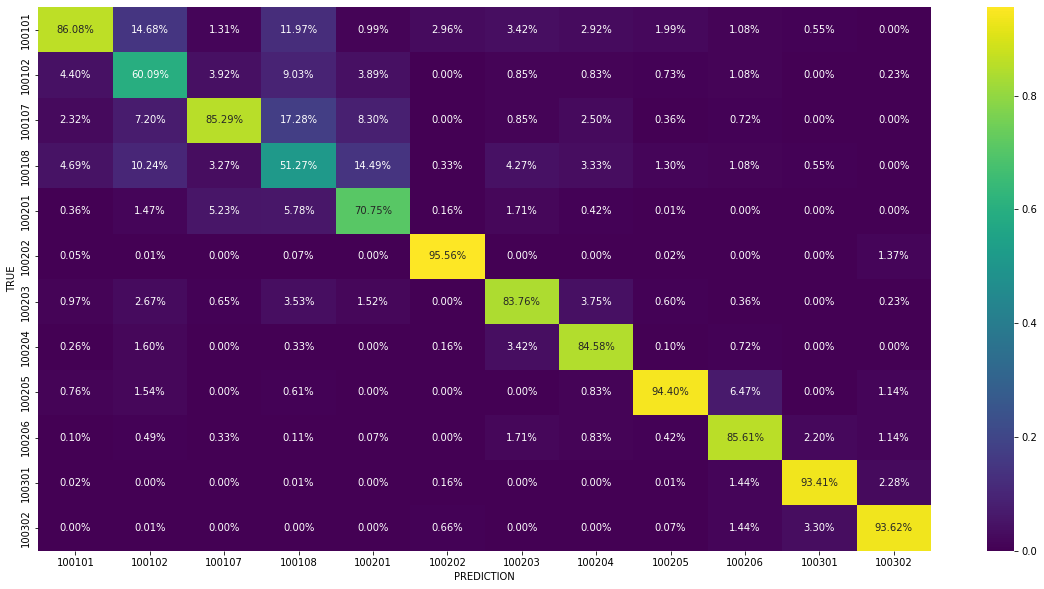

In [11]:
y_=y.copy()
y_['PREDICTION']=y_predict
y_['TRUE']=y_.nama_valid
cf_matrix=y_.pivot_table(columns='PREDICTION',index='TRUE',values='nama_valid',aggfunc='count').fillna(0)
plt.figure(figsize=(20, 10))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='viridis')

### [04. Export Model]

In [16]:
import os
import dill
from google.cloud import storage

with open('ml_output/07_final_model/model_final.pickle', 'wb') as handle:
    dill.dump([best_,fs], handle, protocol=pickle.HIGHEST_PROTOCOL)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'config/gcp_store.json'
client = storage.Client()
bucket = client.get_bucket('bps-gcp-bucket')
file_name='MLST2023/model/final-model/'+pic_+'_model.pickle'
bucket.blob(file_name).upload_from_filename('ml_output/07_final_model/model_final.pickle')